In [39]:
import pandas as pd
import numpy as np

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FixedLocator, FixedFormatter
from textwrap import fill
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

import glob

import os

In [40]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

from utils.common_functions import save_or_show, load_df


Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


# Deployment

In [41]:
path = r"../data/table-28-graduates"
df = load_df(path, skip_rows=13)

In [42]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })

In [43]:

def keep_totals_slice(df, filters):
    """
    Filters a DataFrame by multiple equality conditions passed as keyword args.
    Example:
        keep_totals_slice(df,
            {
                "CAH level marker": "CAH level 3",
                "Level of study": "All",
                "Mode of study": "All",
                "Category marker": "Sex",
                "Category": "Female"
            }
        )
    """
    mask = pd.Series(True, index=df.index)
    for col, value in filters.items():
        mask &= df[col].eq(value)
    return df.loc[mask].copy()


In [44]:

# def filter_scope(d, custom=("10", "11", "13")):
#     keep = d["CAH level subject"].str.startswith(custom, na=False)
#     df_keep = d[keep].copy()
#     return df_keep

In [45]:
# def ensure_subject_label_has_no_code(d):
#     if "Subject" not in d.columns:
#         d["Subject"] = d["CAH level subject"].str.replace(
#             r"^\s*\d{2}-\d{2}-\d{2}\s+", "", regex=True
#         ).str.strip()
#     return d

In [46]:
# def build_pivot(d):
#     pvt = d.pivot_table(index="Academic Year", columns="Subject",
#                         values="Number", aggfunc="sum").fillna(0)
#     order = (pvt.index.str.slice(0, 4).astype(int)).argsort()
#     pvt = pvt.iloc[order]
#     return pvt

In [47]:
# def select_top_columns(pvt, top_n=8):
#     latest_year = pvt.index.max()
#     top_cols = pvt.loc[latest_year].sort_values(ascending=False).head(top_n).index
#     pvt_top = pvt[top_cols].copy()
#     return pvt_top

In [48]:
# def plot_lines(pvt_top, title, ylabel, out_basename, chart_dir, show_legend=True, y_major_locator=1000, y_minor_locator=200):

#     publication_rc()
#     fig, ax = plt.subplots(constrained_layout=True, figsize=(12,6))
#     pvt_top.plot(ax=ax, lw=1.3, legend=show_legend)

#     ax.set_title(fill(title, width=60), pad=25, fontsize=15)
#     ax.title.set_wrap(True)

#     ax.set_xlabel("Academic Year", labelpad=15, fontsize=12)
#     ax.set_ylabel(ylabel, labelpad=12, fontsize=12)

#     ax.yaxis.set_major_locator(MultipleLocator(y_major_locator))
#     ax.yaxis.set_minor_locator(MultipleLocator(y_minor_locator))
#     ax.grid(True, which="both", axis="x", linestyle="--", alpha=0.5)
#     ax.grid(True, which="major", axis="y", linestyle="--", alpha=0.5)
#     ax.grid(True, which="minor", axis="y", linestyle=":",  alpha=0.2)

#     xpos = np.arange(pvt_top.shape[0])
#     ax.xaxis.set_major_locator(FixedLocator(xpos))
#     ax.xaxis.set_major_formatter(FixedFormatter(list(pvt_top.index)))
#     ax.tick_params(axis="x", labelrotation=30)

#     for t in ax.get_yticklabels():
#         t.set_rotation(30)
#         t.set_ha("right")
#     ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
   
#     if show_legend:
#         ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), frameon=False)

#     fig.set_constrained_layout_pads(
#         h_pad=0.10,  
#         w_pad=0.05,  
#         hspace=0.20, 
#         wspace=0.02
#     )

#     save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)

In [49]:
# def filter(df_, cah, top_n: int | None = None):
#     d = filter_scope(df_, custom=cah)
#     d = ensure_subject_label_has_no_code(d)
#     if top_n is None:
#         TOP_N = d["Subject"].nunique()
#     else:
#         TOP_N = top_n
#     pvt = build_pivot(d)
#     pvt_top = select_top_columns(pvt, top_n=TOP_N)
#     return pvt_top

In [59]:
slice = { 
    "Subject area of degree": "10 Engineering and technology",
    "Level of qualification obtained": "All",
    "Mode of former study": "All",
    "Interim study": "Include significant interim study",
}
df_keep = keep_totals_slice(df, slice)

df_grad = df_keep[~df_keep["Activity"].isin(["Total with known outcomes", "Non-respondents", "Total"])].copy()
df_grad.sample(20)
# df_grad = df_keep.copy()

,UKPRN,Provider name,Subject area of degree,Activity,Interim study,Level of qualification obtained,Mode of former study,Academic year,Number,Dest
2239865,10007138,The University of Northampton,10 Engineering and technology,Employment and further study,Include significant interim study,All,All,2019/20,5,Other
4155875,10006022,Solent University,10 Engineering and technology,Unemployed,Include significant interim study,All,All,2021/22,10,Unemployed
126829,10000961,Brunel University London,10 Engineering and technology,Part-time employment,Include significant interim study,All,All,2017/18,20,In work
1719960,10007856,Aberystwyth University,10 Engineering and technology,"Other including travel, caring for someone or ...",Include significant interim study,All,All,2019/20,0,Other
2252528,10001282,University of Northumbria at Newcastle,10 Engineering and technology,Full-time further study,Include significant interim study,All,All,2019/20,20,Further study
3297686,10008098,Study Group,10 Engineering and technology,Unknown pattern of employment,Include significant interim study,All,All,2020/21,0,Other
2186070,10004180,The Manchester Metropolitan University,10 Engineering and technology,Voluntary or unpaid work,Include significant interim study,All,All,2019/20,0,Other
4903015,10020634,North West Regional College,10 Engineering and technology,Full-time employment,Include significant interim study,All,All,2022/23,15,In work
13899,10000093,Accrington and Rossendale College,10 Engineering and technology,Unknown pattern of employment,Include significant interim study,All,All,2017/18,0,Other
4466769,10000975,Buckinghamshire New University,10 Engineering and technology,"Other including travel, caring for someone or ...",Include significant interim study,All,All,2022/23,0,Other


In [60]:
# import pandas as pd
# import numpy as np

# # 1) Filter to Engineering (subject area at CAH1=10, or however your file flags Eng)
# # eng = df_grad[df_grad["Subject area of degree"].eq("10 Engineering and technology")].copy()

# # 2) Keep only outcome rows
# #   In many HESA extracts: Category marker could be "Activity" or "Graduate activity"
# # out = eng[eng["Category marker"].str.contains("activity", case=False, na=False)].copy()

# # 3) Harmonise destination categories across DLHE & Graduate Outcomes
# cat_map = {
#     # Graduate Outcomes style
#     "Full-time employment": "In work",
#     "Part-time employment": "In work",
#     "Employment and further study": "In work & study",
#     "Full-time further study": "Further study",
#     "Unknown pattern of further study": "Further study",
#     "Part-time further study": "Part-time further study",
#     "Unemployed": "Unemployed",
#     "Voluntary or unpaid work": "Other",
#     "Other including travel, caring for someone or retired	": "Other",
#     "Unknown pattern of employment": "Other",
# }

# df_grad["Dest"] = df_grad["Activity"].map(lambda x: cat_map.get(str(x), str(x)))

# # 4) Total per year (denominator) and destination shares
# year_tot = df_grad.groupby("Academic year", as_index=False)["Number"].sum().rename(columns={"Number":"YearTotal"})
# by_dest  = (df_grad.groupby(["Academic year","Dest"], as_index=False)["Number"].sum()
#               .merge(year_tot, on="Academic year", how="left"))
# by_dest["Pct"] = 100 * by_dest["Number"] / by_dest["YearTotal"]

# # 5) Employment rate (line): In work + In work & study
# emp = (by_dest[by_dest["Dest"].isin(["In work","In work & study"])]
#           .groupby("Academic year", as_index=False)["Number"].sum()
#           .merge(year_tot, on="Academic year"))
# emp["Employment rate (%)"] = 100 * emp["Number"] / emp["YearTotal"]

# # Optional: Positive outcomes = In work + In work & study + Further study
# pos = (by_dest[by_dest["Dest"].isin(["In work","In work & study","Further study"])]
#           .groupby("Academic year", as_index=False)["Number"].sum()
#           .merge(year_tot, on="Academic year"))
# pos["Positive outcome rate (%)"] = 100 * pos["Number"] / pos["YearTotal"]


In [61]:
def normalize_year_order(df, year_col="Academic year"):
    # Put academic years in chronological order (e.g., "2017/18" -> 2017 key)
    key = df[year_col].astype(str).str.slice(0, 4).astype(int)
    return df.assign(_yearkey=key).sort_values(["_yearkey", year_col]).drop(columns="_yearkey")


In [62]:
# 1) Map Activity -> Dest (5 buckets)
cat_map = {
    # Work-only
    "Full-time employment": "In work",
    "Part-time employment": "In work",
    "Full-time paid work": "In work",
    "Part-time paid work": "In work",

    # Work & study
    "Employment and further study": "In work & study",
    "Work and further study": "In work & study",
    "Full-time work and study": "In work & study",
    "Part-time work and study": "In work & study",

    # Further study-only
    "Full-time further study": "Further study",
    "Part-time further study": "Further study",
    "Further study": "Further study",

    # Unemployed
    "Unemployed": "Unemployed",
    "Assumed to be unemployed": "Unemployed",

    # Everything else → Other
    "Voluntary or unpaid work": "Other",
    "Other including travel, caring for someone or ...": "Other",
    "Other activity": "Other",
    "Unknown": "Other",
    "Unknown pattern of employment": "Other",
    "Unknown pattern of further study": "Other",
}


In [63]:
def to_bucket(activity: str) -> str:
    a = str(activity).strip()
    return cat_map.get(a, "Other")  # default to Other for any unexpected label


In [64]:
df = df_grad.copy()
df["Dest"] = df["Activity"].map(to_bucket)

# (Optional) restrict to Engineering if your frame mixes subjects
df = df[df["Subject area of degree"].eq("10 Engineering and technology")].copy()

# (Optional) apply any “Total / Include significant interim study / All” filters you use elsewhere
# e.g., df = df.query("`Interim study` == 'Include significant interim study' and `Level of qualification obtained` == 'All' and `Mode of former study` == 'All'")

# 2) Aggregate counts by year x destination
by_dest_counts = (df.groupby(["Academic year", "Dest"], as_index=False)["Number"]
                    .sum())
by_dest_counts = normalize_year_order(by_dest_counts, "Academic year")

# Totals per year (for employment rate)
year_tot = (by_dest_counts.groupby("Academic year", as_index=False)["Number"]
                        .sum()
                        .rename(columns={"Number": "YearTotal"}))

# Employment rate = (In work + In work & study) / total
emp = (by_dest_counts[by_dest_counts["Dest"].isin(["In work","In work & study"])]
          .groupby("Academic year", as_index=False)["Number"].sum()
          .merge(year_tot, on="Academic year", how="left"))
emp["Employment rate (%)"] = 100 * emp["Number"] / emp["YearTotal"]
emp = normalize_year_order(emp, "Academic year")

In [65]:
def plot_outcomes_stacked_counts(by_dest_counts, title, out_basename, chart_dir="chart-5"):
    # Pivot to counts
    pvt = (by_dest_counts.pivot_table(index="Academic year",
                                      columns="Dest",
                                      values="Number",
                                      aggfunc="sum")
                        .fillna(0))

    # Column order
    order = ["In work", "In work & study", "Further study", "Unemployed", "Other"]
    cols = [c for c in order if c in pvt.columns] + [c for c in pvt.columns if c not in order]
    pvt = pvt[cols]

    # Chronological x-order
    pvt = pvt.iloc[pvt.index.str.slice(0, 4).astype(int).argsort()]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    bottom = np.zeros(len(pvt))
    colors = {
        "In work":           "#1f77b4",
        "In work & study":   "#2ca02c",
        "Further study":     "#9467bd",
        "Unemployed":        "#d62728",
        "Other":             "#8c564b",
    }
    for col in pvt.columns:
        ax.bar(pvt.index, pvt[col].values, bottom=bottom,
               label=col, color=colors.get(col, None))
        bottom += pvt[col].values

    ax.set_ylabel("Number of respondents", fontweight="bold")
    ax.set_xlabel("Academic year")
    ax.set_title(title, fontweight="bold", pad=12)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.tick_params(axis="x", labelrotation=30)
    ax.legend(title="Destination", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    plt.tight_layout()
    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


In [66]:
# def plot_outcomes_stacked(by_dest, title, out_basename, chart_dir="chart-5"):
#     # pivot to % by year
#     pvt = by_dest.pivot_table(index="Academic year", columns="Dest", values="Pct", aggfunc="sum").fillna(0)
#     # consistent order for legend / stack
#     order = ["In work","In work & study","Further study","Unemployed","Other"]
#     cols = [c for c in order if c in pvt.columns] + [c for c in pvt.columns if c not in order]
#     pvt = pvt[cols]

#     publication_rc()
#     fig, ax = plt.subplots(figsize=(12,6))
#     bottom = np.zeros(len(pvt))
#     x = np.arange(len(pvt.index))

#     for col in pvt.columns:
#         ax.bar(pvt.index, pvt[col].values, bottom=bottom, label=col)
#         bottom += pvt[col].values

#     ax.set_ylabel("Share of respondents (%)", fontweight="bold")
#     ax.set_xlabel("Academic year")
#     ax.set_title(title, fontweight="bold", pad=12)
#     ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
#     ax.grid(True, axis="y", linestyle="--", alpha=0.4)
#     ax.legend(title="Destination", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

#     plt.tight_layout()
#     save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)

# from matplotlib.ticker import StrMethodFormatter

def plot_outcomes_stacked_counts(by_dest, title, out_basename, chart_dir="chart-5"):
    """
    Stacked bars of *counts* (Number) by destination per academic year.
    Expects `by_dest` with columns: ["Academic year","Dest","Number", ...]
    """

    # 1) Pivot to counts
    pvt = (by_dest
           .pivot_table(index="Academic year", columns="Dest",
                        values="Number", aggfunc="sum")
           .fillna(0))

    # 2) Order destinations consistently (and keep any extras at the end)
    order = ["In work", "In work & study", "Further study", "Unemployed", "Other"]
    cols = [c for c in order if c in pvt.columns] + [c for c in pvt.columns if c not in order]
    pvt = pvt[cols]

    # 3) Ensure academic years plot in chronological order
    #    (assumes labels like "2014/15")
    if isinstance(pvt.index, pd.Index) and pvt.index.dtype == "object":
        order_idx = pvt.index.str.slice(0, 4).astype(int).argsort()
        pvt = pvt.iloc[order_idx]

    publication_rc()
    fig, ax = plt.subplots(figsize=(12, 6))

    # Optional: a fixed color map so categories are consistent across figures
    dest_colors = {
        "In work":           "#1f77b4",
        "In work & study":   "#2ca02c",
        "Further study":     "#9467bd",
        "Unemployed":        "#d62728",
        "Other":             "#8c564b",
    }
    colors = [dest_colors.get(c, None) for c in pvt.columns]

    bottom = np.zeros(len(pvt))
    for i, col in enumerate(pvt.columns):
        ax.bar(pvt.index, pvt[col].values, bottom=bottom, label=col,
               color=colors[i] if colors[i] else None)
        bottom += pvt[col].values

    # Axes & formatting
    ax.set_ylabel("Number of respondents", fontweight="bold")
    ax.set_xlabel("Academic year")
    ax.set_title(title, fontweight="bold", pad=12)
    ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.tick_params(axis="x", labelrotation=30)

    # Legend outside
    ax.legend(title="Destination", bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

    fig.tight_layout()
    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)



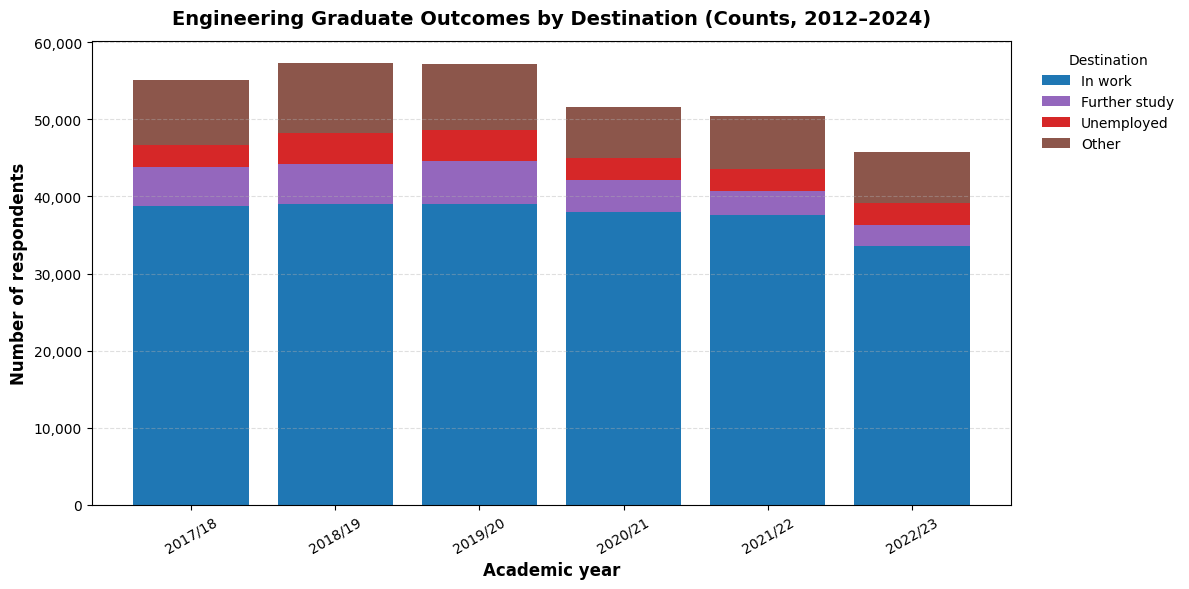

In [67]:
# plot_outcomes_stacked(
#     by_dest,
#     title="Engineering Graduate Outcomes by Destination (2012–2024, % of respondents)",
#     out_basename="eng_outcomes_stacked"
# )


plot_outcomes_stacked_counts(
    by_dest_counts,
    title="Engineering Graduate Outcomes by Destination (Counts, 2012–2024)",
    out_basename="eng_outcomes_stacked_counts"
)
